<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Time-Series-Project-using-Zillow-Data" data-toc-modified-id="Time-Series-Project-using-Zillow-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Time-Series Project using Zillow Data</a></span></li><li><span><a href="#Selecting-Zipcodes-for-analysis" data-toc-modified-id="Selecting-Zipcodes-for-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Selecting Zipcodes for analysis</a></span></li><li><span><a href="#Step-1:-Load-the-Data/Filtering-for-Chosen-Zipcodes" data-toc-modified-id="Step-1:-Load-the-Data/Filtering-for-Chosen-Zipcodes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Step 1: Load the Data/Filtering for Chosen Zipcodes</a></span></li><li><span><a href="#Step-2:-Data-Preprocessing" data-toc-modified-id="Step-2:-Data-Preprocessing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Step 2: Data Preprocessing</a></span></li><li><span><a href="#Step-3:-EDA-and-Visualization" data-toc-modified-id="Step-3:-EDA-and-Visualization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Step 3: EDA and Visualization</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Observations:" data-toc-modified-id="Observations:-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Observations:</a></span></li><li><span><a href="#Observations:" data-toc-modified-id="Observations:-5.0.2"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>Observations:</a></span></li><li><span><a href="#Observations:" data-toc-modified-id="Observations:-5.0.3"><span class="toc-item-num">5.0.3&nbsp;&nbsp;</span>Observations:</a></span></li><li><span><a href="#Observations:" data-toc-modified-id="Observations:-5.0.4"><span class="toc-item-num">5.0.4&nbsp;&nbsp;</span>Observations:</a></span></li><li><span><a href="#Observations:" data-toc-modified-id="Observations:-5.0.5"><span class="toc-item-num">5.0.5&nbsp;&nbsp;</span>Observations:</a></span></li></ul></li></ul></li><li><span><a href="#Step-4:-Reshape-from-Wide-to-Long-Format" data-toc-modified-id="Step-4:-Reshape-from-Wide-to-Long-Format-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Step 4: Reshape from Wide to Long Format</a></span><ul class="toc-item"><li><span><a href="#Observations:" data-toc-modified-id="Observations:-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Observations:</a></span></li></ul></li><li><span><a href="#Step-5:-ARIMA-Modeling-to-Predict-Values-from-2017+-and-5-Year-Forecast" data-toc-modified-id="Step-5:-ARIMA-Modeling-to-Predict-Values-from-2017+-and-5-Year-Forecast-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Step 5: ARIMA Modeling to Predict Values from 2017+ and 5 Year Forecast</a></span><ul class="toc-item"><li><span><a href="#Observations-for-San-Francisco-94621" data-toc-modified-id="Observations-for-San-Francisco-94621-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Observations for San Francisco 94621</a></span></li><li><span><a href="#Observations-for-Austin-78648" data-toc-modified-id="Observations-for-Austin-78648-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Observations for Austin 78648</a></span></li><li><span><a href="#Observations-for-Seattle-98418" data-toc-modified-id="Observations-for-Seattle-98418-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Observations for Seattle 98418</a></span></li><li><span><a href="#Observations-for-Dallas-76105" data-toc-modified-id="Observations-for-Dallas-76105-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Observations for Dallas 76105</a></span></li><li><span><a href="#Observations-for-Boston-03868" data-toc-modified-id="Observations-for-Boston-03868-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Observations for Boston 03868</a></span></li></ul></li><li><span><a href="#Step-6:-Conclusions" data-toc-modified-id="Step-6:-Conclusions-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Step 6: Conclusions</a></span></li><li><span><a href="#Step-7:-Further-Work" data-toc-modified-id="Step-7:-Further-Work-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Step 7: Further Work</a></span></li></ul></div>

# Time-Series Project using Zillow Data

This project uses a modified csv file of data pulled from Zillow to provide average sale prices of houses per month, per zip-code. The objective of this project is to select 5 zip-codes and provide investment advice or guidance for someone looking to make a profit investing. The steps are outlined below: 

# Selecting Zipcodes for analysis

https://www.businessinsider.com/us-metro-area-city-best-economy-ranking-2019-8#1-san-francisco-california-the-per-capita-gdp-of-90296-and-average-weekly-wage-of-1932-were-both-by-far-the-highest-among-the-30-biggest-metro-areas-and-the-unemployment-rate-of-22-was-tied-with-austin-as-the-lowest-15

Using the article listed above. One zipcode from each of the top 5 metro areas in the US is chosen for analysis. These 5 areas are chose based on their unemployment rate, per-capita GDP, and other factors which can be found in the article. From these 5 metro areas I found the three lowest selling prices for 2018-04. I then compared the average price in 2013 or as early as the data is found and 2018 and found the zipcode with the highest return. Time-series analysis modeling is provided for these 5 zipcodes.

Top 5 Metro Areas:
1. San Francisco
2. Austin
3. Seattle
4. Dallas
5. Boston


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import warnings
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams

df = pd.read_csv('zillow_data.csv')

In [2]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Step 2: Data Preprocessing

How to determine what is the best zipcode in each metro area?
1. Find 3 lowest mean sale prices for the final columns 2018-4
2. Find the zipcode with the highest return

In [50]:
#returns 3 smallest 
def three_smallest(df):
    """Takes in a dataframe and returns the rows containing the 
       three smallest values for the 2018-04 column"""
    return df.nsmallest(3, '2018-04')

In [51]:
san_fran_df = three_smallest(df[df['Metro'] == 'San Francisco'])
san_fran_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
4712,97822,94621,Oakland,CA,San Francisco,Alameda,4713,NaN,NaN,NaN,...,363100,367400,371600,376600,381900,387400,390400,393100,399700,405500
310,97717,94509,Antioch,CA,San Francisco,Contra Costa,311,142500.0,141500.0,140400.0,...,376000,378900,381600,385000,387500,390100,393600,397800,403500,408700
27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100


In [52]:
austin_df = three_smallest(df[df['Metro'] == 'Austin'])
austin_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
14230,82512,55951,Le Roy,MN,Austin,Mower,14231,53900.0,54000.0,54300.0,...,79100,79600,80300,80700,82100,83900,84200,84800,86800,88800
3236,82482,55912,Austin,MN,Austin,Mower,3237,59300.0,59400.0,59600.0,...,86700,86800,86900,87200,88900,91100,91800,92300,93800,95300
9229,92582,78648,Luling,TX,Austin,Caldwell,9230,25000.0,25200.0,25500.0,...,101200,102000,102400,102300,102400,103000,103300,104100,105900,107000


In [53]:
seattle_df = three_smallest(df[df['Metro'] == 'Seattle'])
seattle_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
4187,99791,98409,Tacoma,WA,Seattle,Pierce,4188,88800.0,88800.0,88700.0,...,209400,211900,214200,216700,220200,224800,229100,232000,234400,236300
8622,99797,98418,Tacoma,WA,Seattle,Pierce,8623,83200.0,83400.0,83700.0,...,216100,219200,221500,223700,227000,231300,234900,237400,239900,242100
3653,99786,98404,Tacoma,WA,Seattle,Pierce,3654,92500.0,92500.0,92500.0,...,220200,222400,224700,227200,230900,235800,240100,243400,246600,248800


In [54]:
dallas_df = three_smallest(df[df['Metro'] == 'Dallas-Fort Worth'])
dallas_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
12127,90957,75496,Wolfe City,TX,Dallas-Fort Worth,Hunt,12128,50500.0,50800.0,51200.0,...,66400,67500,68700,69100,69800,70400,70900,71500,72500,73300
9356,90763,75210,Dallas,TX,Dallas-Fort Worth,Dallas,9357,NaN,NaN,NaN,...,67000,66800,66400,66600,68400,70900,72900,75100,76900,77300
6033,91250,76105,Fort Worth,TX,Dallas-Fort Worth,Tarrant,6034,33100.0,33600.0,34100.0,...,70700,72900,75000,76400,76400,76400,76800,77400,78300,78800


In [55]:
boston_df = three_smallest(df[df['Metro'] == 'Boston'])
boston_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
10024,59260,3868,Rochester,NH,Boston,Strafford,10025,69300.0,69100.0,68900.0,...,156600,158500,160600,161200,161500,161700,162400,163200,163600,163500
4786,59259,3867,Rochester,NH,Boston,Strafford,4787,76900.0,76900.0,76900.0,...,169600,170900,172600,175000,177400,178400,178600,179500,181000,182200
13415,59274,3887,Middleton,NH,Boston,Strafford,13416,77900.0,78000.0,78100.0,...,179200,181800,183200,184700,187100,189200,190500,191600,192800,193700


# Step 3: EDA and Visualization

In [8]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [56]:
def city_plot(df, start_year, title):
    """Takes in a dataframe, beggining year for average sales, and zipcode. 
       It then makes a bar plot of the three zipcodes for that metro area from 
       the beggining of data until the end."""
    
    df_plot = df[['RegionName', start_year, '2018-04']]
    df_plot.plot.bar(x='RegionName', figsize=(8,8), title=title)
    plt.show()

In [57]:
def city_roi(df, start_year):
    """takes a dataframe and starting year for average sales and calculates
       the return on investment"""
    
    df['roi'] = df['2018-04'] - df[start_year]
    zipcode = df['RegionName'].ravel()
    roi = ((df['2018-04'] - df[start_year])/(df[start_year])).ravel()
    for i in range(len(roi)):
        print('From', start_year[:4], 'to 2018, the average return for zip-code {} was: {}%'.format(zipcode[i], roi[i]*100))
    return zipcode[roi.tolist().index(roi.max())]

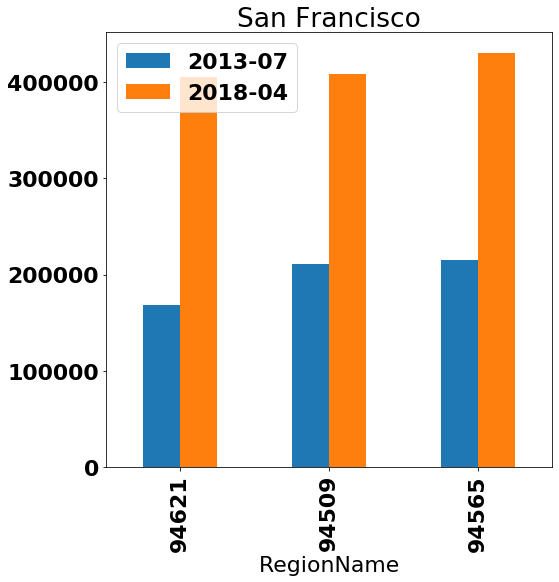

From 2013 to 2018, the average return for zip-code 94621 was: 140.08288928359974%
From 2013 to 2018, the average return for zip-code 94509 was: 94.15676959619952%
From 2013 to 2018, the average return for zip-code 94565 was: 99.58236658932714%


In [58]:
#Plot each city individually calling the city_plot function
city_plot(san_fran_df, '2013-07', 'San Francisco')
#Shows the returns for each zipcode, returns zip with highest return
san_fran_largest_return = city_roi(san_fran_df, '2013-07')

### Observations:
All three zipcodes have grown substantially in the past 5 years. The zipcode to be modeled later will be 94621 since it had the highest ROI and would hopefully continue to perfomr similarly for future investors. The same principles are applied to the other 4 cities and a zipcode is selected for further analysis.

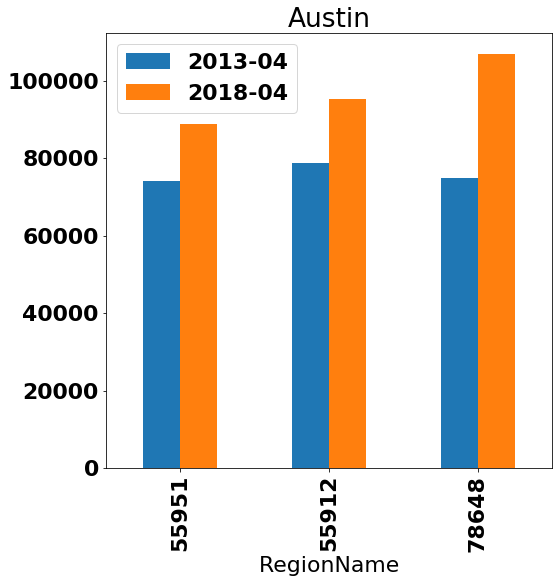

From 2013 to 2018, the average return for zip-code 55951 was: 19.67654986522911%
From 2013 to 2018, the average return for zip-code 55912 was: 20.785804816223067%
From 2013 to 2018, the average return for zip-code 78648 was: 42.66666666666667%


In [60]:
city_plot(austin_df, '2013-04', 'Austin')
austin_largest_return = city_roi(austin_df, '2013-04')

### Observations:
The ROI was not as significant as San Francisco, but an ROI of 42% is relatively high so 78648 will be the zipcode chosen for Austin

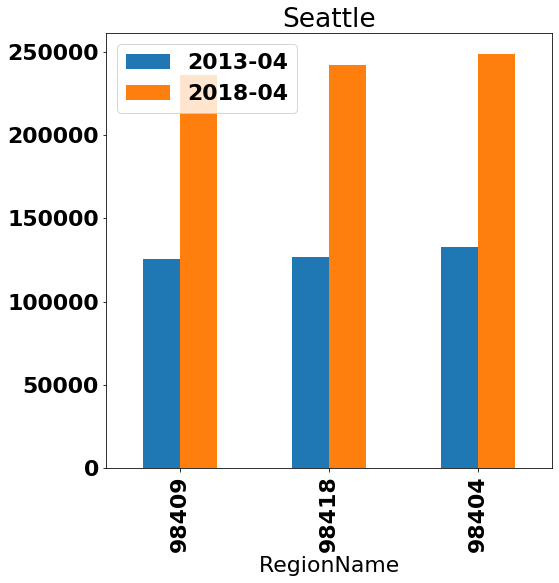

From 2013 to 2018, the average return for zip-code 98409 was: 87.83783783783784%
From 2013 to 2018, the average return for zip-code 98418 was: 91.08129439621152%
From 2013 to 2018, the average return for zip-code 98404 was: 87.34939759036145%


In [61]:
city_plot(seattle_df, '2013-04', 'Seattle')
seattle_largest_return = city_roi(seattle_df, '2013-04')

### Observations:
Once again you would have almost doubled your money if you had invested in Seattle real estate in early 2013. The top ROI was 91% so 98418 will recieve further analysis.

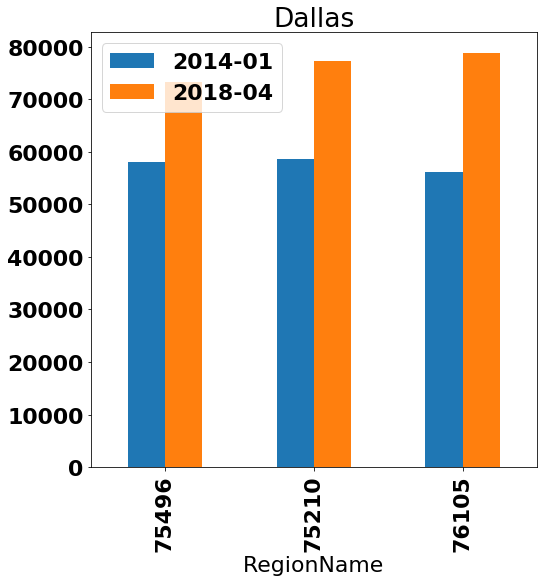

From 2014 to 2018, the average return for zip-code 75496 was: 26.161790017211707%
From 2014 to 2018, the average return for zip-code 75210 was: 31.91126279863481%
From 2014 to 2018, the average return for zip-code 76105 was: 40.46345811051694%


In [62]:
city_plot(dallas_df, '2014-01', 'Dallas')
dallas_largest_return = city_roi(dallas_df, '2014-01')

### Observations:
The first thing to note about Dallas is that the starting and ending prices are low compared to say San Francisco. A return of 40% is still an amazing investment and Dallas is one of the top 5 metro areas in the US. Zipcode 76105 will be used for further analysis.

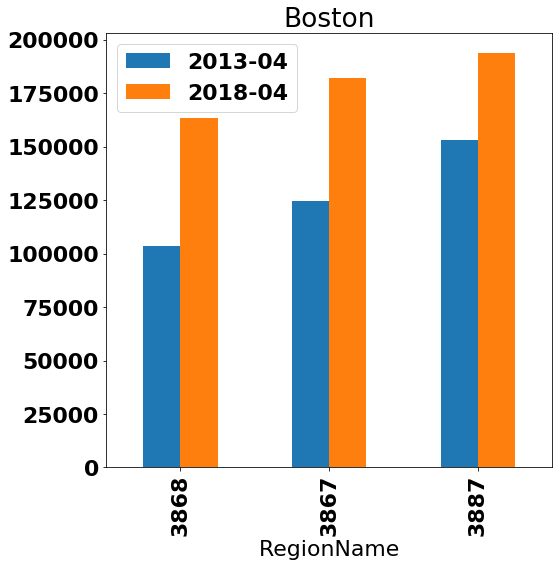

From 2013 to 2018, the average return for zip-code 3868 was: 57.818532818532816%
From 2013 to 2018, the average return for zip-code 3867 was: 46.34538152610442%
From 2013 to 2018, the average return for zip-code 3887 was: 26.43603133159269%


In [63]:
city_plot(boston_df, '2013-04', 'Boston')
boston_largest_return = city_roi(boston_df, '2013-04')

### Observations:
Boston's zipcodes start with a 0 in front which is why they are only 4 characters long. Boston falls around the middle in terms of average prices. The highest return was 58% which means 03868 will be used for further analysis.

# Step 4: Reshape from Wide to Long Format

In [16]:
def melt_data(df):
    """puts the dataframe from the csv into a useable format for time-series"""
    
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 
                                  'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted


In [44]:
def get_df_to_model(df, zipcode):
    """Takes in a metro dataframe, and the zipcode with the highest ROI. 
    It then calls the melt_data function to get the df ready for time-series. 
    Next any column that isn't needed will be dropped and the remaining values 
    are plotted against time"""
    
    df = df.drop(columns=['roi'])
    melted_df = melt_data(df)
    model_df = melted_df[melted_df['RegionName'] == zipcode]
    model_df.set_index(model_df['time'], inplace=True)
    model_df.drop(['time'], axis=1, inplace=True)
    model_df = model_df.asfreq('MS')
    model_df.drop(['City', 'State', 'Metro', 'CountyName', 'RegionName', 
                   'RegionID', 'SizeRank'], axis=1,  inplace=True)
    model_df.plot(figsize=(15,6), title=zipcode)
    plt.show()
    return model_df

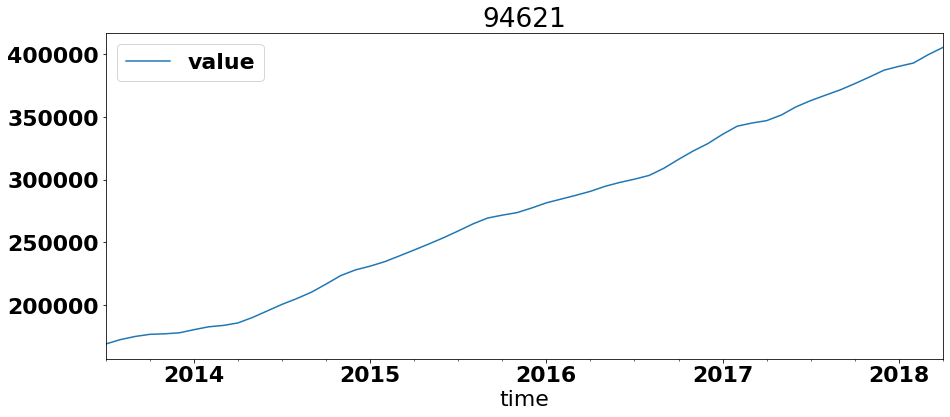

In [64]:
san_fran_model_ts = get_df_to_model(san_fran_df, san_fran_largest_return)

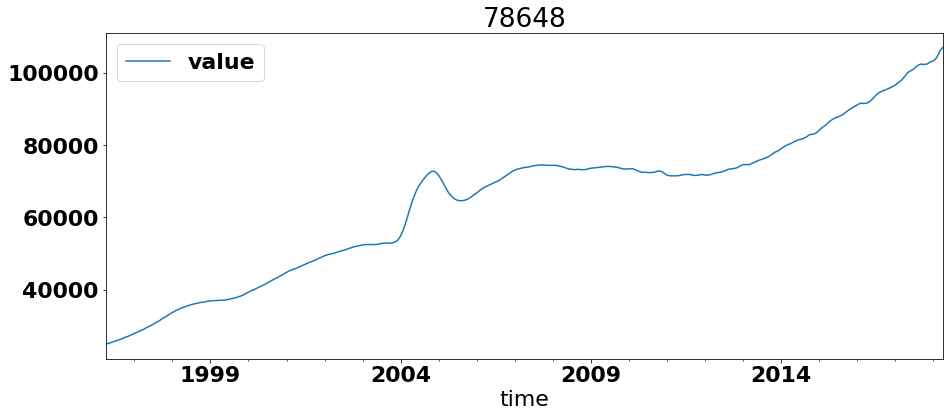

In [65]:
austin_model_ts = get_df_to_model(austin_df, austin_largest_return)

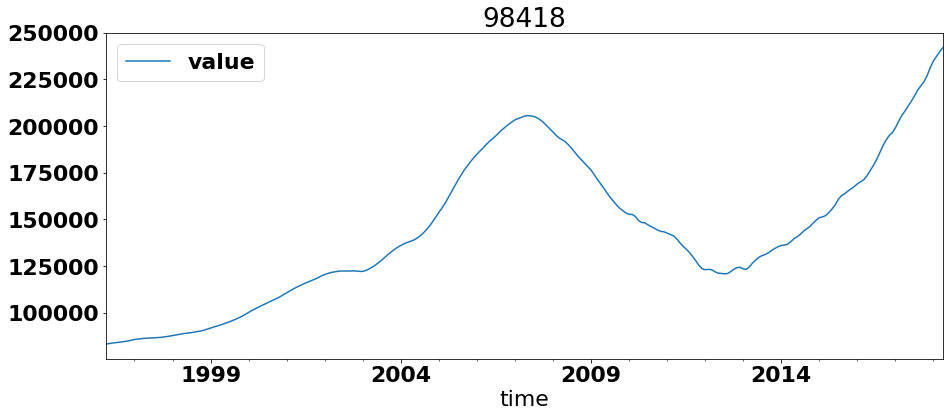

In [66]:
seattle_model_ts = get_df_to_model(seattle_df, seattle_largest_return)

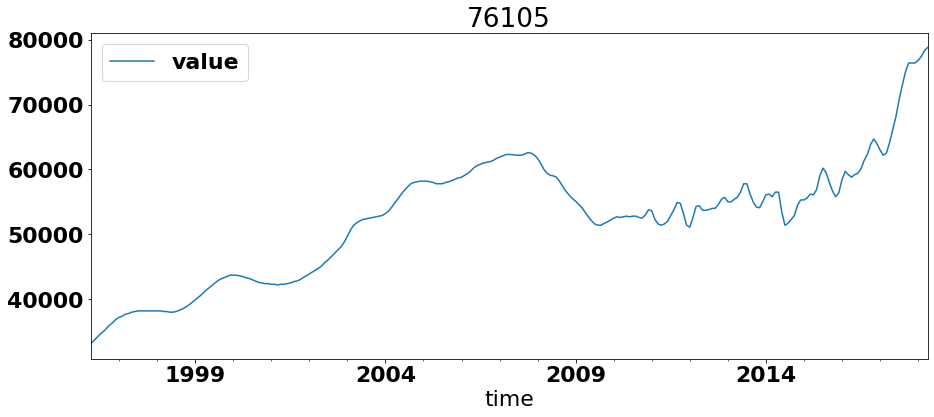

In [67]:
dallas_model_ts = get_df_to_model(dallas_df, dallas_largest_return)

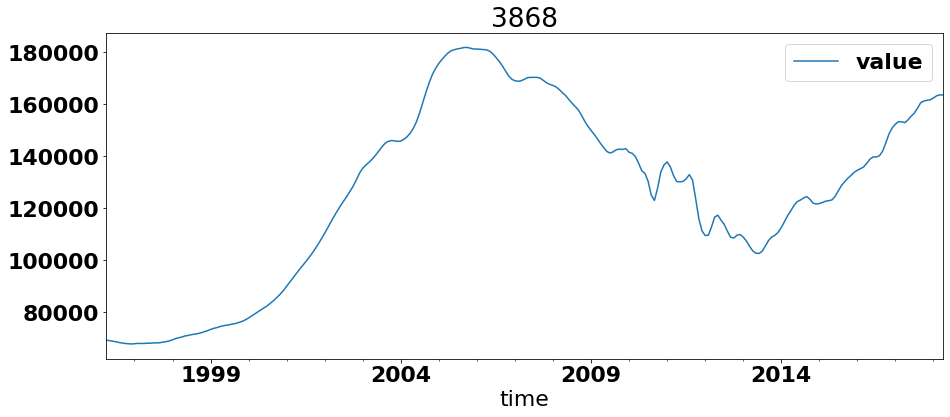

In [68]:
boston_model_ts = get_df_to_model(boston_df, boston_largest_return)

## Observations:
1. For San Francisco, data was only available for 94621 past 2013 that is why the X axis starts later than all the other graphs.
2. For the other 4 zipcodes. There was growth from about 1999 until about 2005, 2006 and then either a decline or small change
3. After 2014 the prices once again start to climb. This was probably caused by the housing market crash and possibly some other factors
4. San Francisco 94621 will probably have the most "accurate" model since it shows a mostly linear increase
5. Austin did not have as strong of a decline as the other zipcodes affected by the housing crash. Austin should have a decent model score as well.

# Step 5: ARIMA Modeling to Predict Values from 2017+ and 5 Year Forecast

In [71]:
def evaluate_arima_model(X, arima_order):
    """Takes in a time-series dataset, and values for pdq. This function uses step forward validation to predict values using a 
    SARIMAX model and returns the mean squared error"""
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = []
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=arima_order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate mse
    error = mean_squared_error(test, predictions)
    return error

In [72]:
def evaluate_models(dataset, p_values, d_values, q_values):
    """Takes a time-series and different values for p, d, and q. This function 
    calls the evaluate_arima_model function to get the mean square error. After 
    going through the combinations of pdq, the lowest mse is printed and the 
    pdq combination is returned"""
    
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    best_model = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order) 
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [24]:
#provide p, d, and q values to be evaluated
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

#find the combination of pdq that provides the lowest mse and save the pdq config
best_san_fran_model_cfg = evaluate_models(san_fran_model_ts.values, p_values, d_values, q_values)

Best ARIMA(1, 0, 2) MSE=1817736.511


In [25]:
best_austin_model_cfg = evaluate_models(austin_model_ts.values, p_values, d_values, q_values)

Best ARIMA(1, 0, 1) MSE=62809.202


In [26]:
best_seattle_model_cfg = evaluate_models(seattle_model_ts.values, p_values, d_values, q_values)

Best ARIMA(2, 0, 2) MSE=209121.829


In [28]:
best_dallas_model_cfg = evaluate_models(dallas_model_ts.values, p_values, d_values, q_values)

Best ARIMA(1, 0, 2) MSE=402330.083


In [29]:
best_boston_model_cfg = evaluate_models(boston_model_ts.values, p_values, d_values, q_values)

Best ARIMA(0, 1, 2) MSE=1033584.718


In [73]:
#run ARIMA, plot, predict, MSE
def arima_test(df, best_order):
    """Takes in a time-series dataframe and an order of pdq. From there it models 
    the df, plots the diagnostics for the df, gets predictions and plots against 
    the actual values from 2017 to the end of the ts. It then predicts dynamically. 
    And finally a forecast is given for the next 5 years"""
    
    #The ARIMA model and summary table
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df,
                                        order=best_order,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
    output = ARIMA_MODEL.fit()
    print(output.summary().tables[1])
    
    #plot diagnositcs
    output.plot_diagnostics(figsize=(14,18))
    plt.gcf().autofmt_xdate()
    plt.show()
    
    #get predictions from 2017-01 to 2018-04
    pred = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
    pred_conf = pred.conf_int()
    
    # Plot real vs predicted values along with confidence interval
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = df['1996':].plot(label='observed')

    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)

    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    plt.legend()

    plt.show()
    
    # Compute the mean square error
    value_forecasted = pred.predicted_mean
    value_truth = df['2017-01-01':]
    mse = ((value_forecasted - value_truth['value']) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    
    #dynamic modeling
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True, full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    
    ax = df['1996':].plot(label='observed', figsize=(20, 15))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), value_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Values')

    plt.legend()
    plt.show()
    
    # Compute the mean square error
    value_forecasted = pred_dynamic.predicted_mean
    value_truth = df['2017-01-01':]
    mse = ((value_forecasted - value_truth['value']) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    
    #forecasting
    prediction = output.get_forecast(steps=60)
    pred_conf = prediction.conf_int()
    
    ax = df.plot(label='observed', figsize=(20, 15))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')

    plt.legend()
    plt.show()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0141      0.002    557.702      0.000       1.011       1.018
ma.L1          1.5514      0.125     12.375      0.000       1.306       1.797
ma.L2          0.9051      0.127      7.142      0.000       0.657       1.154
sigma2      1.234e+06   4.05e-09   3.05e+14      0.000    1.23e+06    1.23e+06


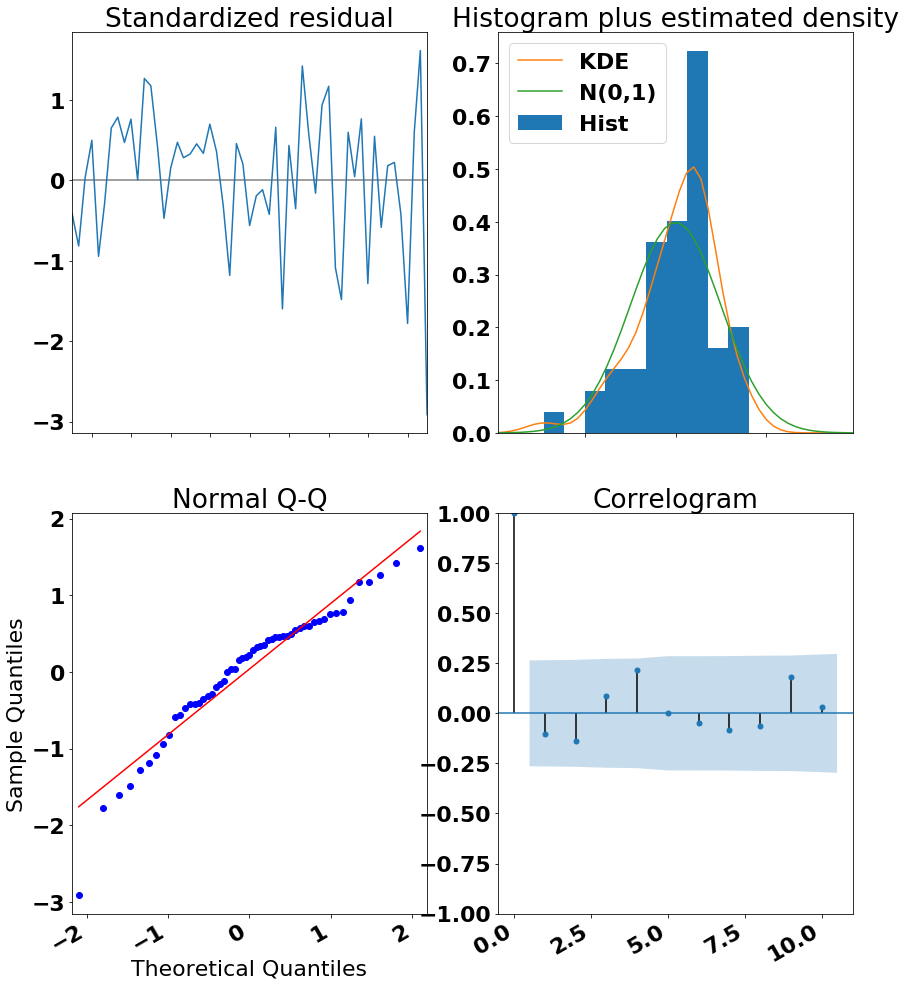

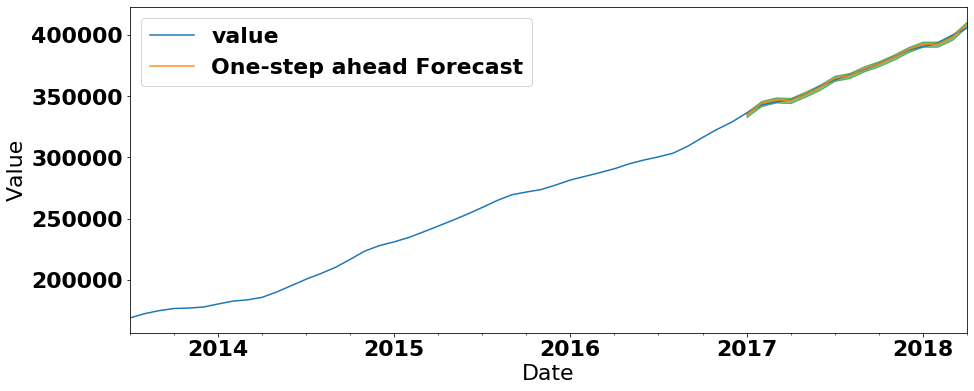

The Mean Squared Error of our forecasts is 1765246.06


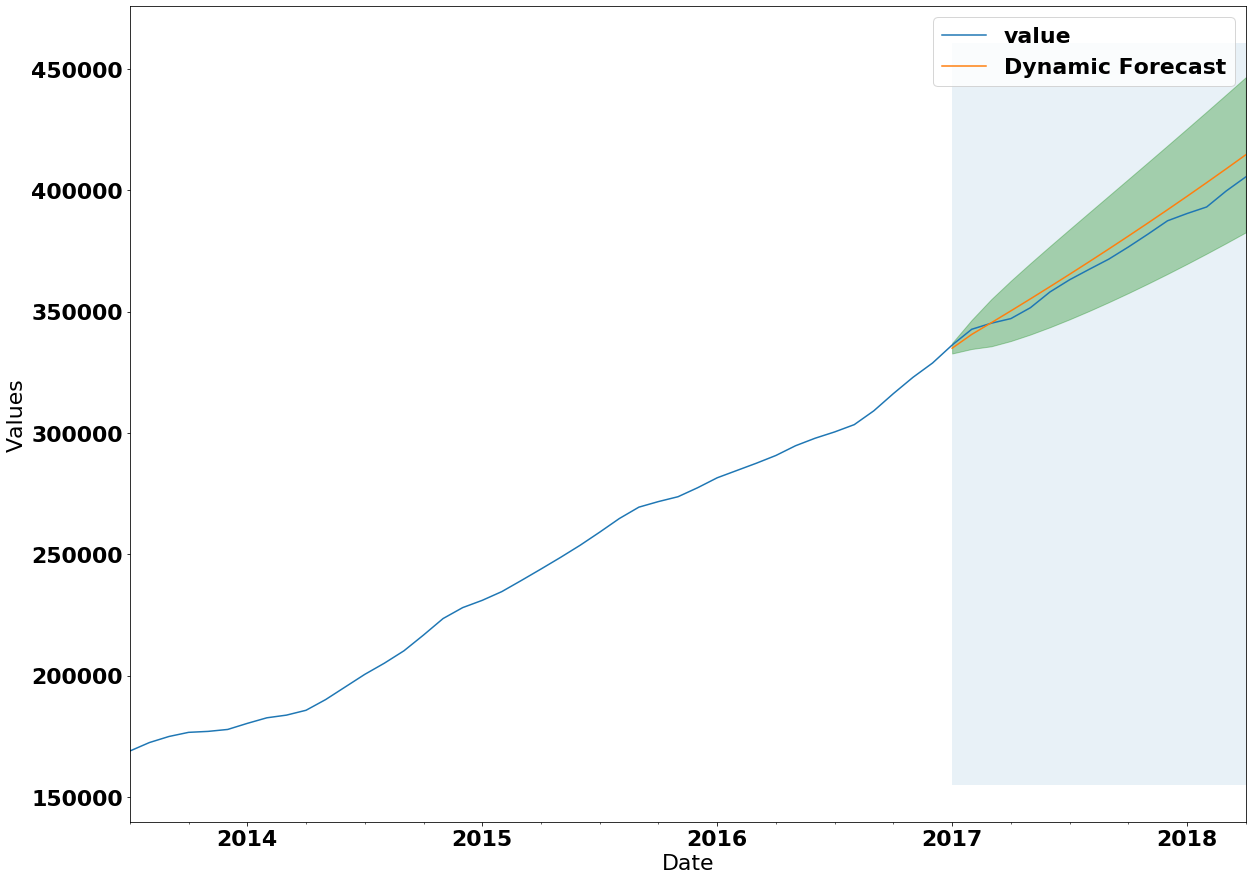

The Mean Squared Error of our forecasts is 27882970.8


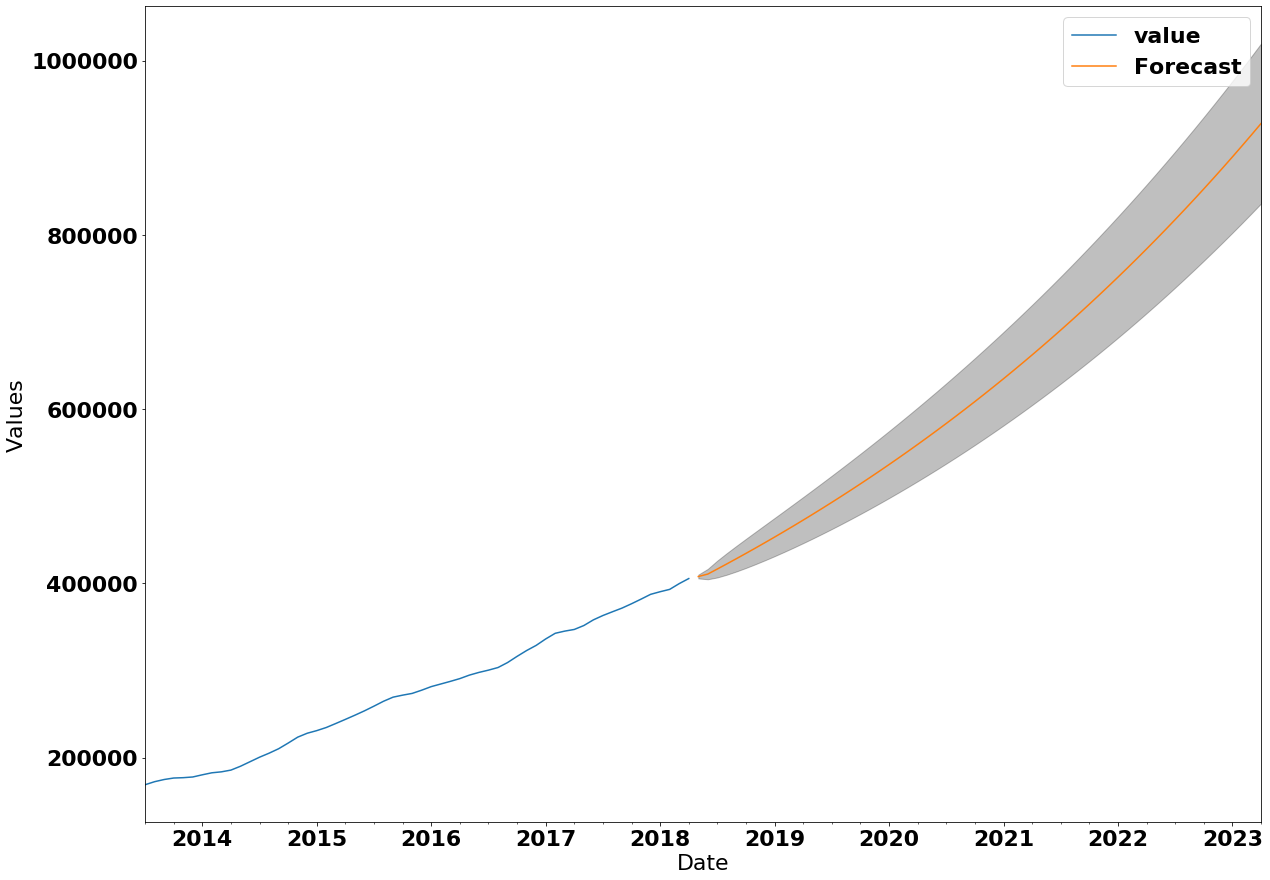

In [42]:
arima_test(san_fran_model_ts, best_san_fran_model_cfg)

## Observations for San Francisco 94621
1. All p-values are below 0.05
2. Looking at the diagnostic plots, you could say that all assumptions are met and this model is serviceable.  
3. Looking at the first prediction plot. The model seems to be doing very well. Especially since the average error was about 1300 which in my opinion is very good for predicting a house value that is several hundred thousand dollars.
4. The dynamic forecast predicts a little high.
5. Forecasting for the next 5 years shows a continued growth and relatively narrow cone of uncertainty

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0044      0.001   1903.453      0.000       1.003       1.005
ma.L1          1.2018      0.060     19.966      0.000       1.084       1.320
sigma2      6.601e+04   5017.680     13.156      0.000    5.62e+04    7.58e+04


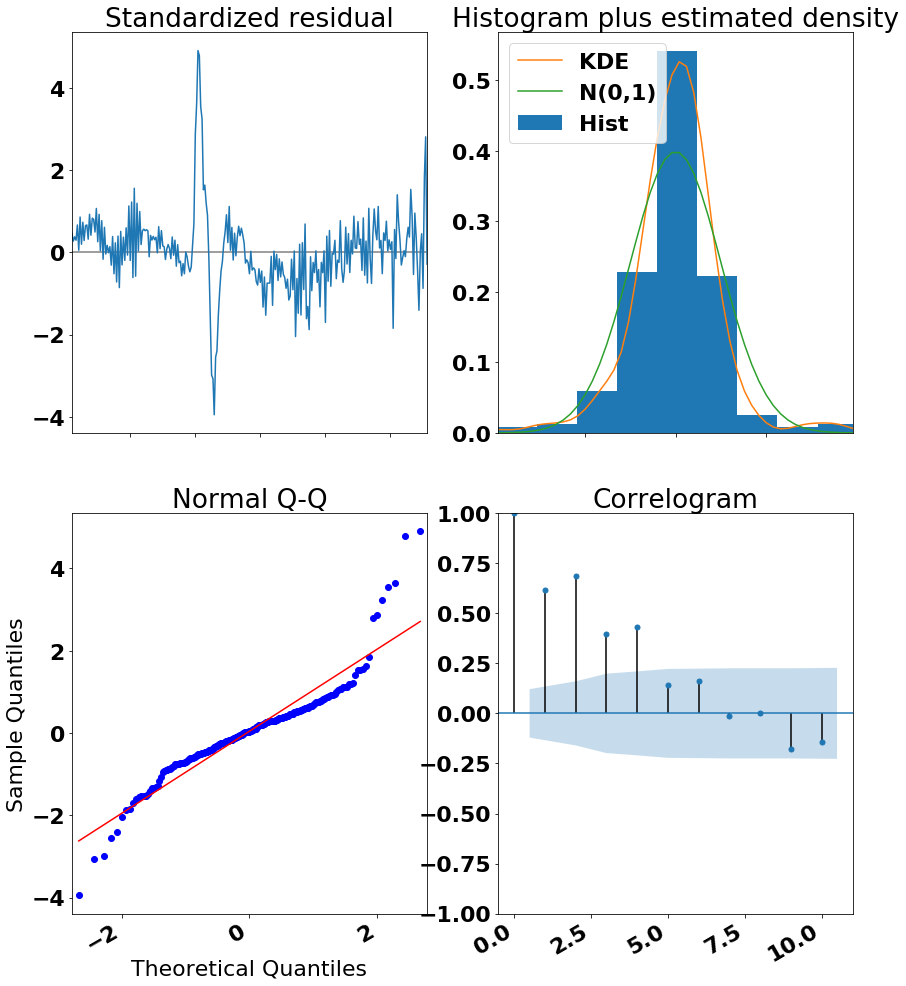

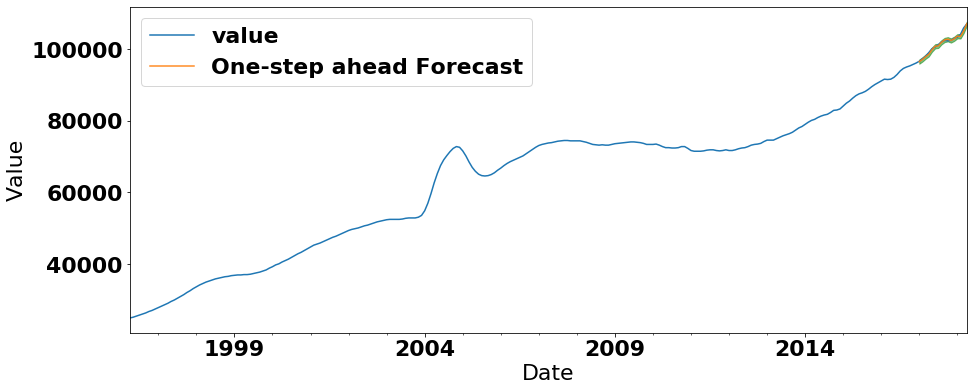

The Mean Squared Error of our forecasts is 116618.42


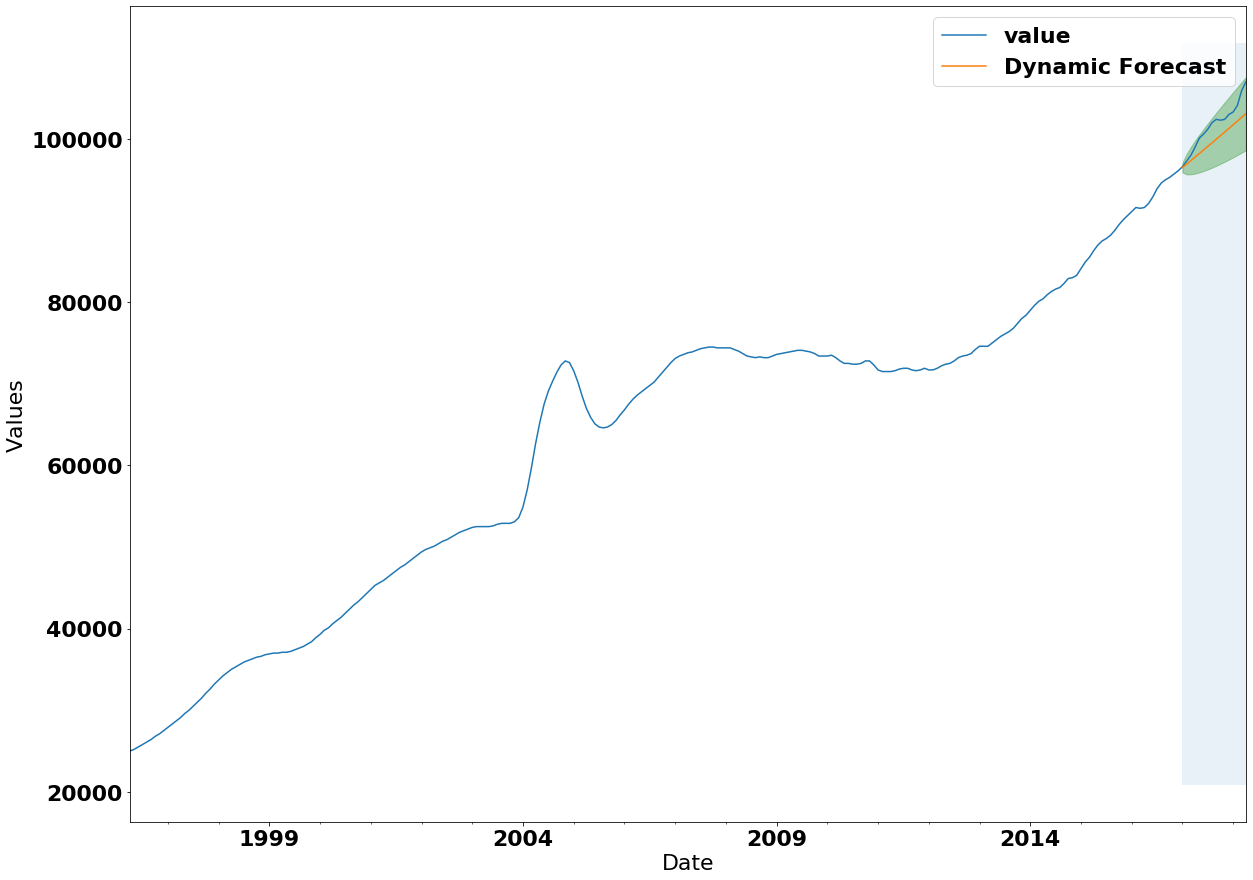

The Mean Squared Error of our forecasts is 4190759.58


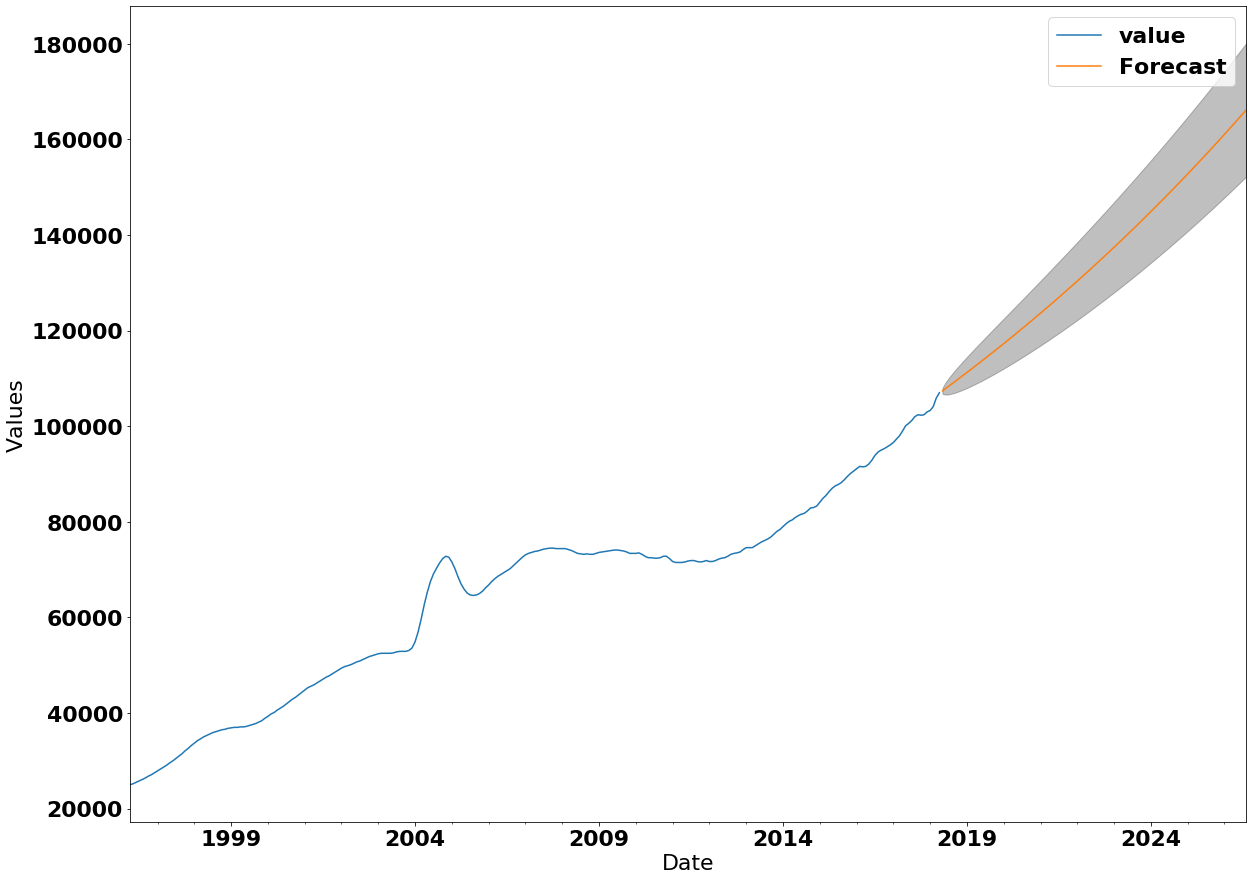

In [32]:
arima_test(austin_model_ts, best_austin_model_cfg)

## Observations for Austin 78648
1. All p-values are below 0.05
2. Looking at the diagnostic plots, it is a little more of a stretch to say that all assumptions are met but they are not too far off.  
3. Looking at the first prediction plot. The model seems to be doing very well. Even better than the San Francisco model which I thought would perform the best. Especially since the average error was about 340 which in my opinion is very good.
4. The dynamic forecast predicts a little low in this case.
5. Forecasting for the next 5 years shows a continued growth and relatively narrow cone of uncertainty

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9449      0.020     95.182      0.000       1.905       1.985
ar.L2         -0.9447      0.021    -46.002      0.000      -0.985      -0.904
ma.L1          0.5465      0.055     10.018      0.000       0.440       0.653
ma.L2          0.0227      0.056      0.406      0.684      -0.087       0.132
sigma2      9.698e+04    7.9e-08   1.23e+12      0.000     9.7e+04     9.7e+04


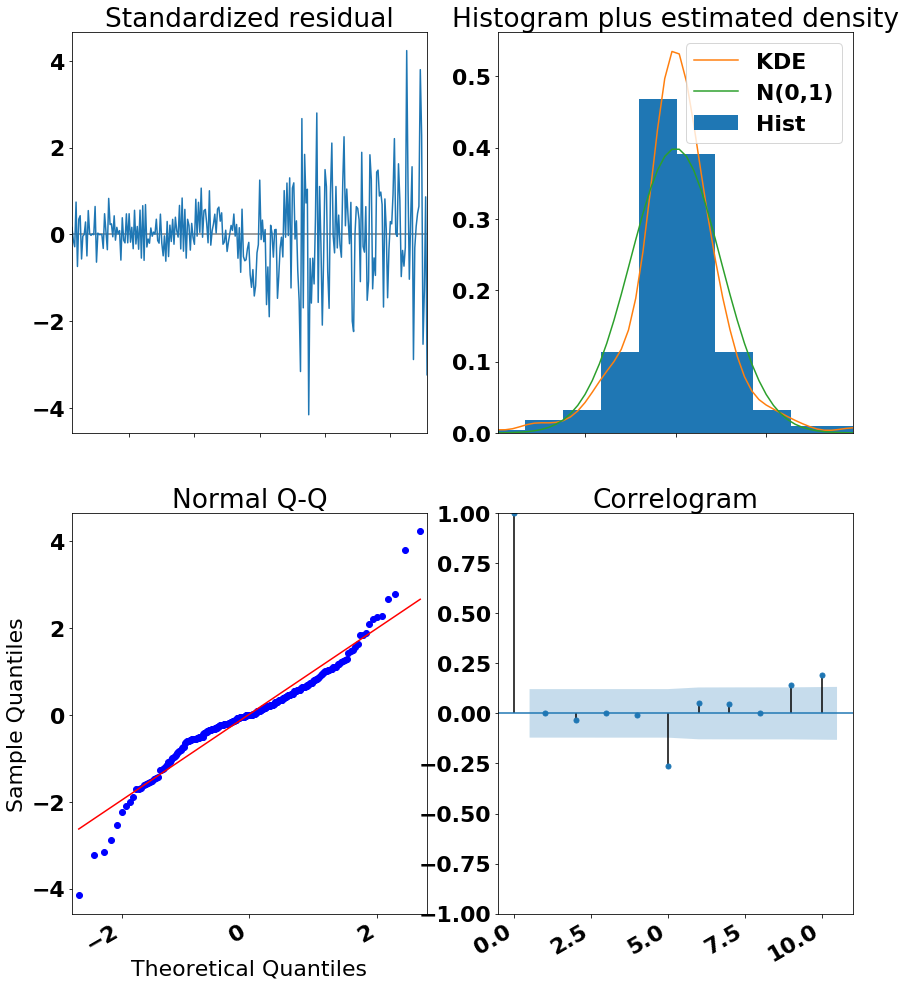

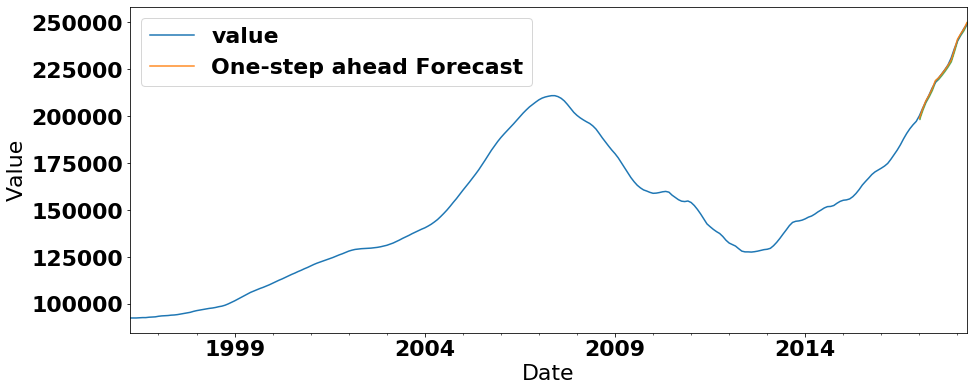

The Mean Squared Error of our forecasts is 427401.61


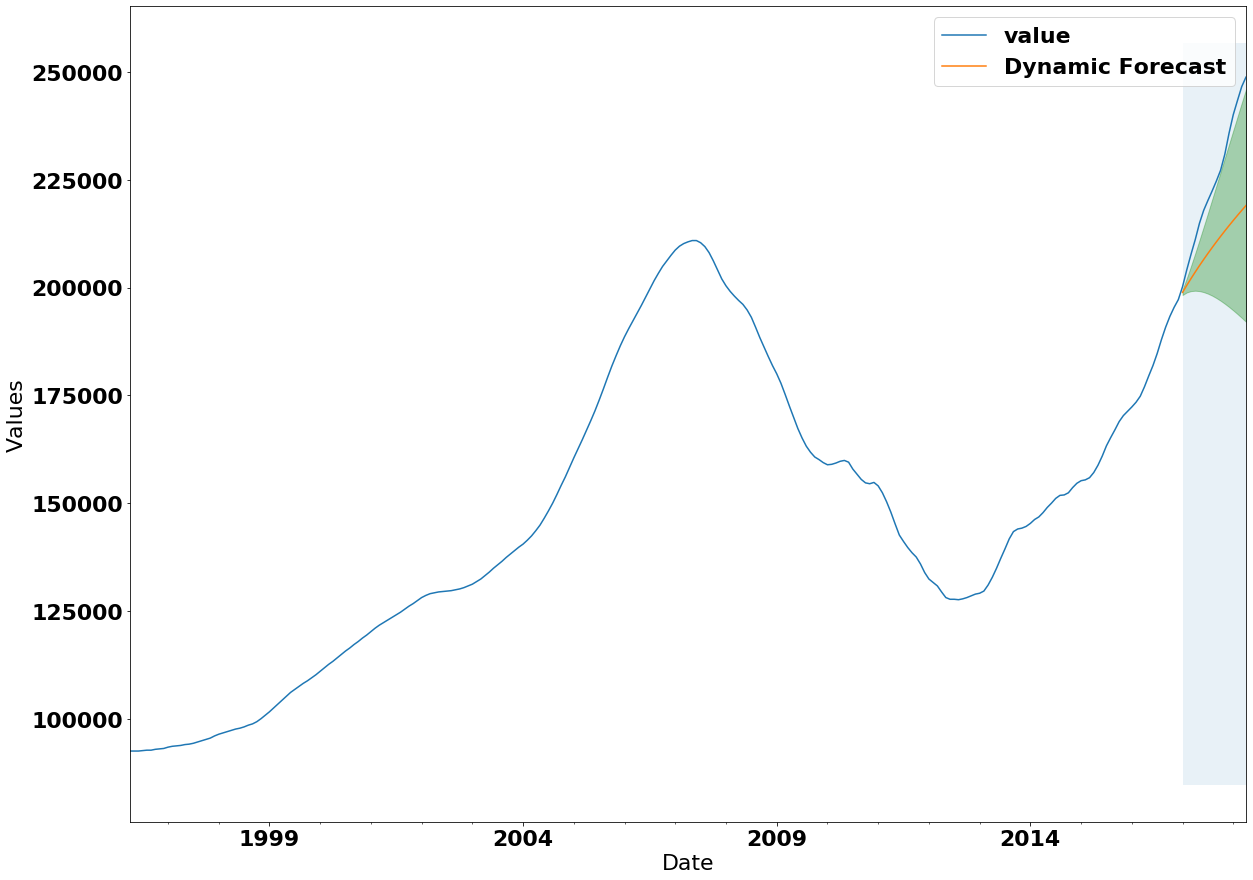

The Mean Squared Error of our forecasts is 305333784.34


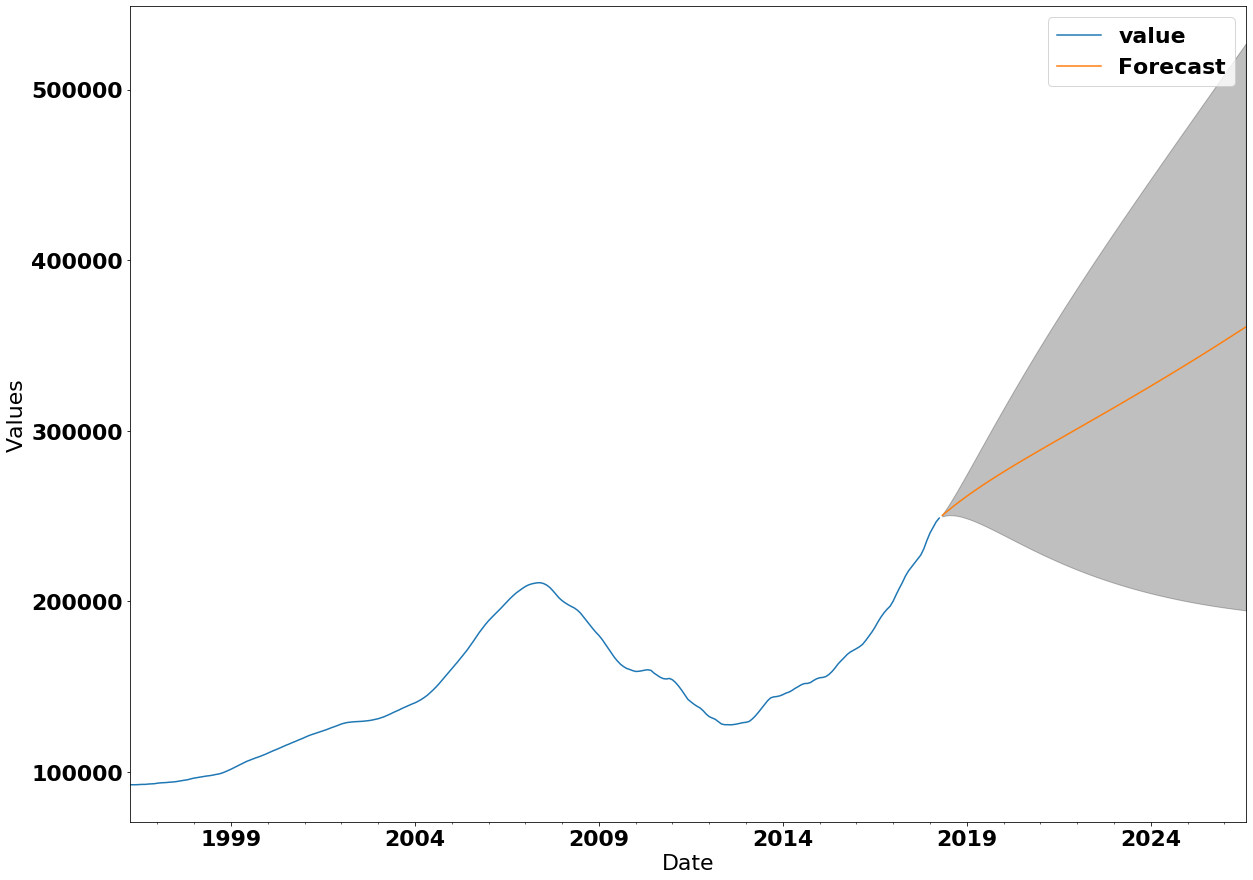

In [33]:
arima_test(seattle_model_ts, best_seattle_model_cfg)

## Observations for Seattle 98418
1. There is one p-value that is not below 0.05
2. Looking at the diagnostic plots, it can be said that assumptions are met.  
3. Looking at the first prediction plot. The model seems to be doing very well.Not quite as good as the Austin model, but not too far off. 
4. The dynamic forecast seems to be pretty off and shows a much lower value than what is true. 
5. Forecasting for the next 5 years shows a continued growth but the cone of uncertainty is rather large and unstable. 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0031      0.001    673.895      0.000       1.000       1.006
ma.L1          1.3606      0.034     40.432      0.000       1.295       1.427
ma.L2          0.6326      0.034     18.511      0.000       0.566       0.700
sigma2      1.771e+05   1.21e+04     14.669      0.000    1.53e+05    2.01e+05


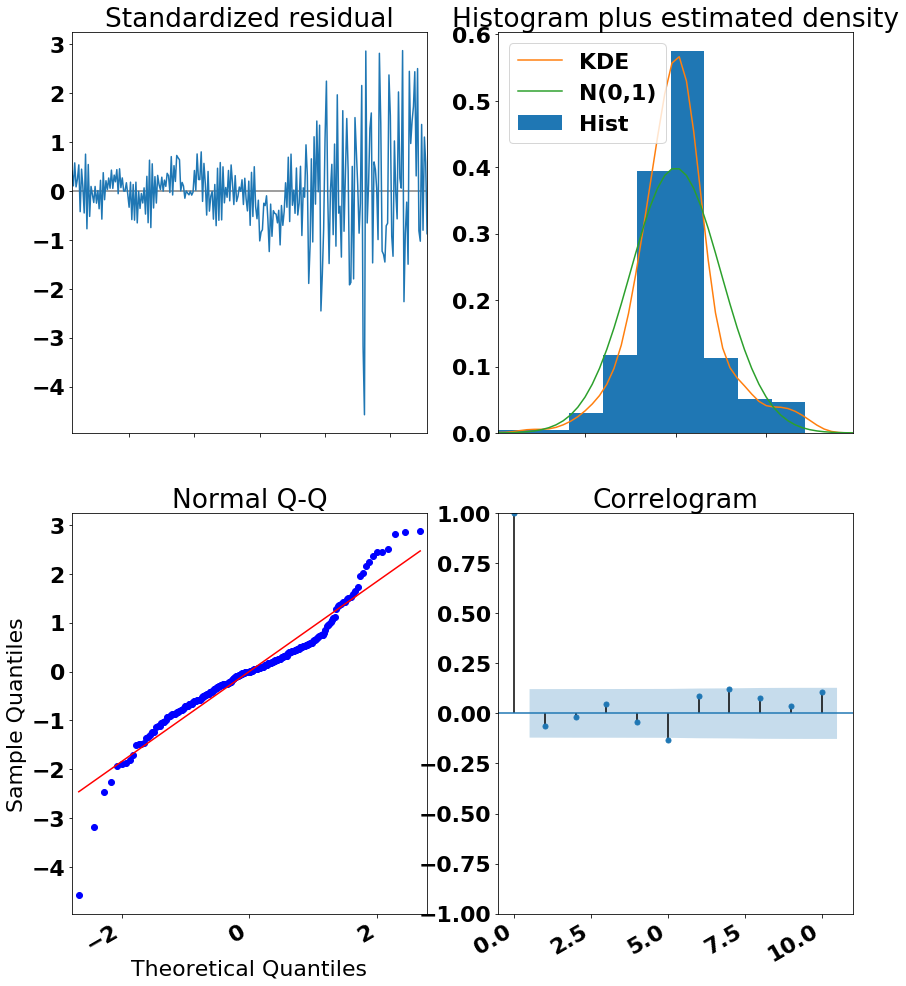

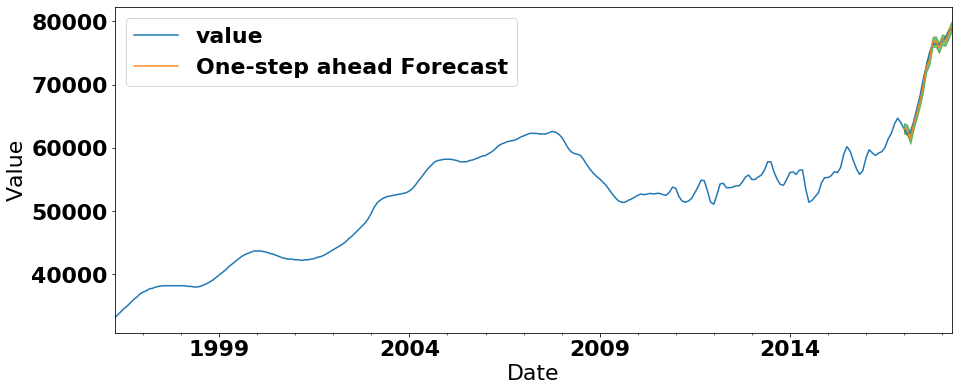

The Mean Squared Error of our forecasts is 365436.55


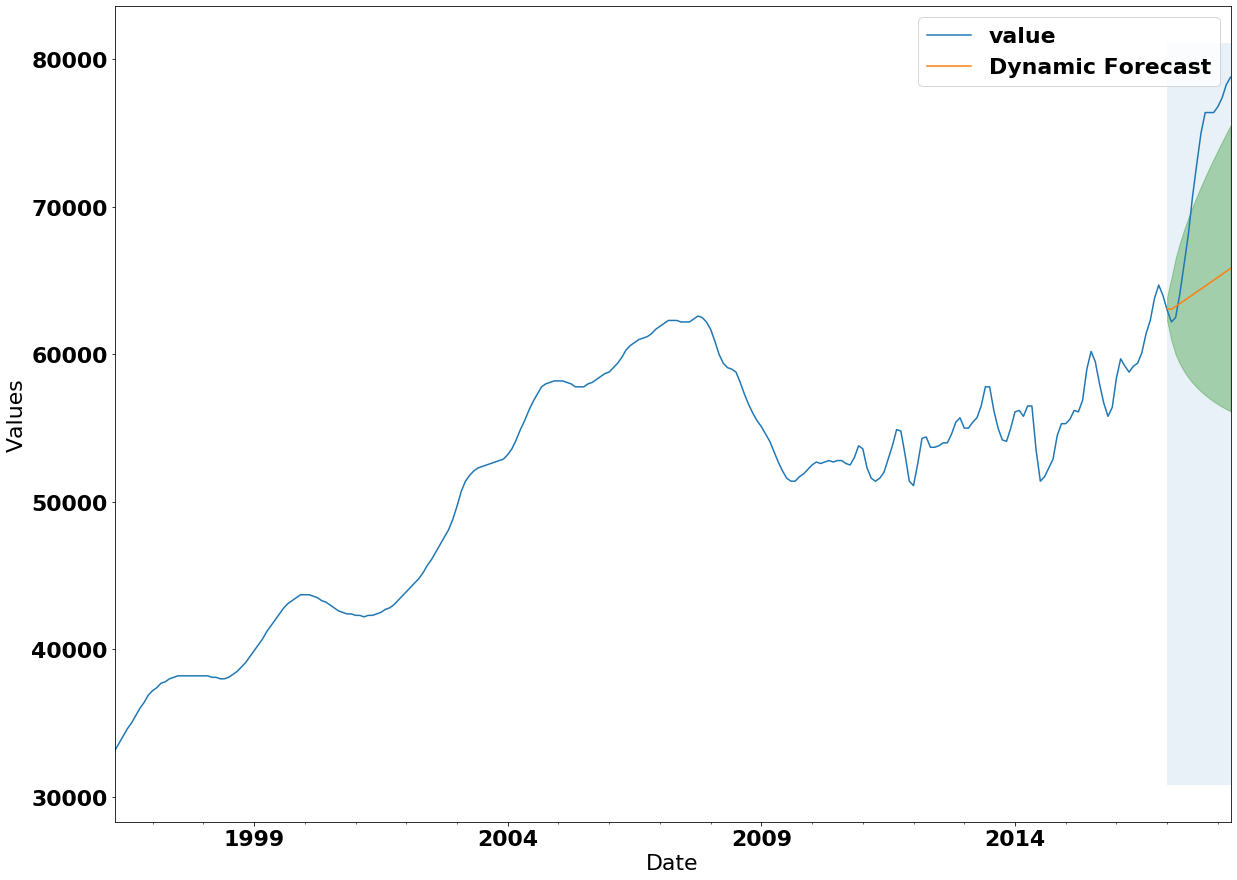

The Mean Squared Error of our forecasts is 79044213.06


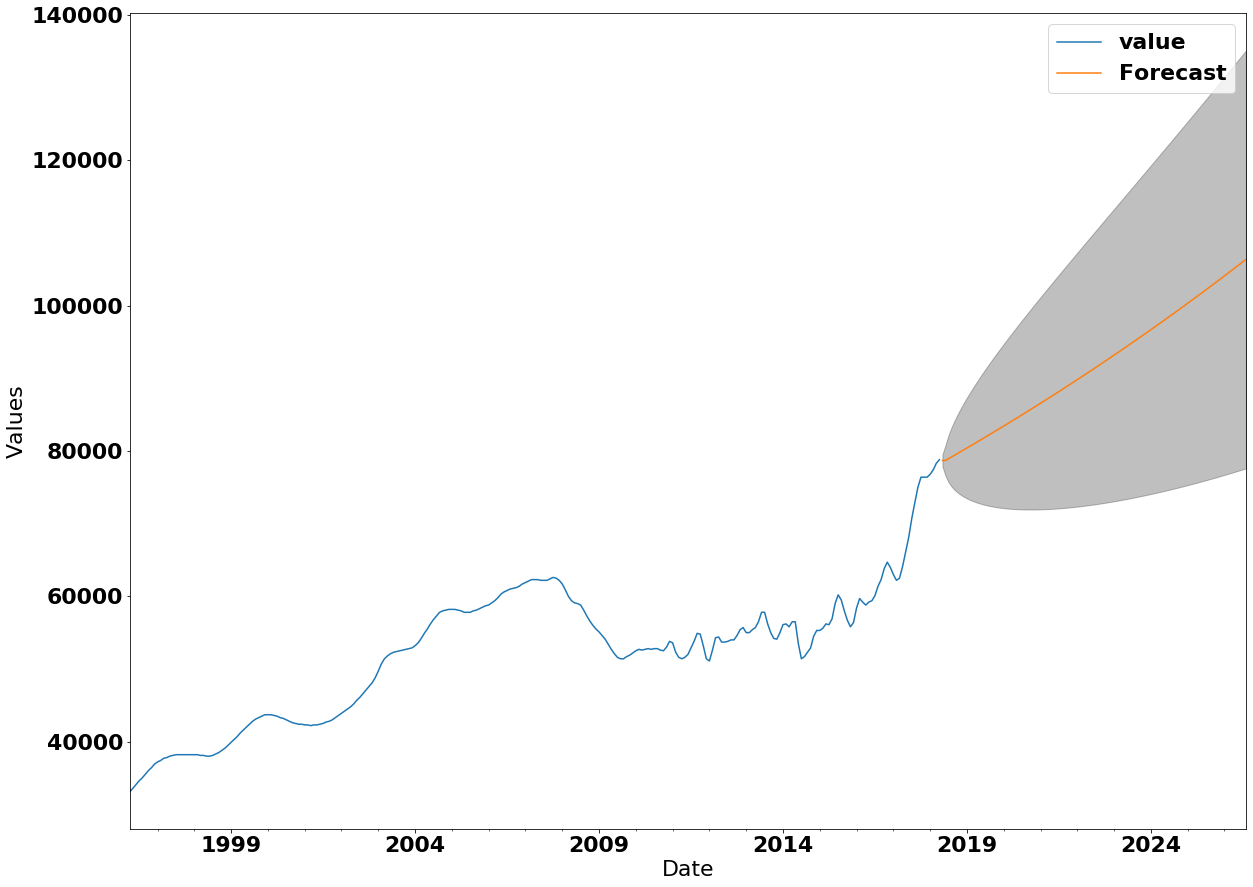

In [34]:
arima_test(dallas_model_ts, best_dallas_model_cfg)

## Observations for Dallas 76105
1. All p-values are below 0.05
2. Looking at the diagnostic plots, it can be said that assumptions are met although it is a bit of a stretch.  
3. Looking at the first prediction plot. The model seems to be doing very well.
4. The dynamic forecast seems to be pretty off and shows a much lower value than what is true. This is probably because there is much more fluctuation between 2011 and 2018.  
5. Forecasting for the next 5 years shows a continued growth but the cone of uncertainty is rather large and unstable. 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.8471      0.052     35.549      0.000       1.745       1.949
ma.L2          1.2900      0.049     26.567      0.000       1.195       1.385
sigma2      3.234e+05   2.79e+04     11.593      0.000    2.69e+05    3.78e+05


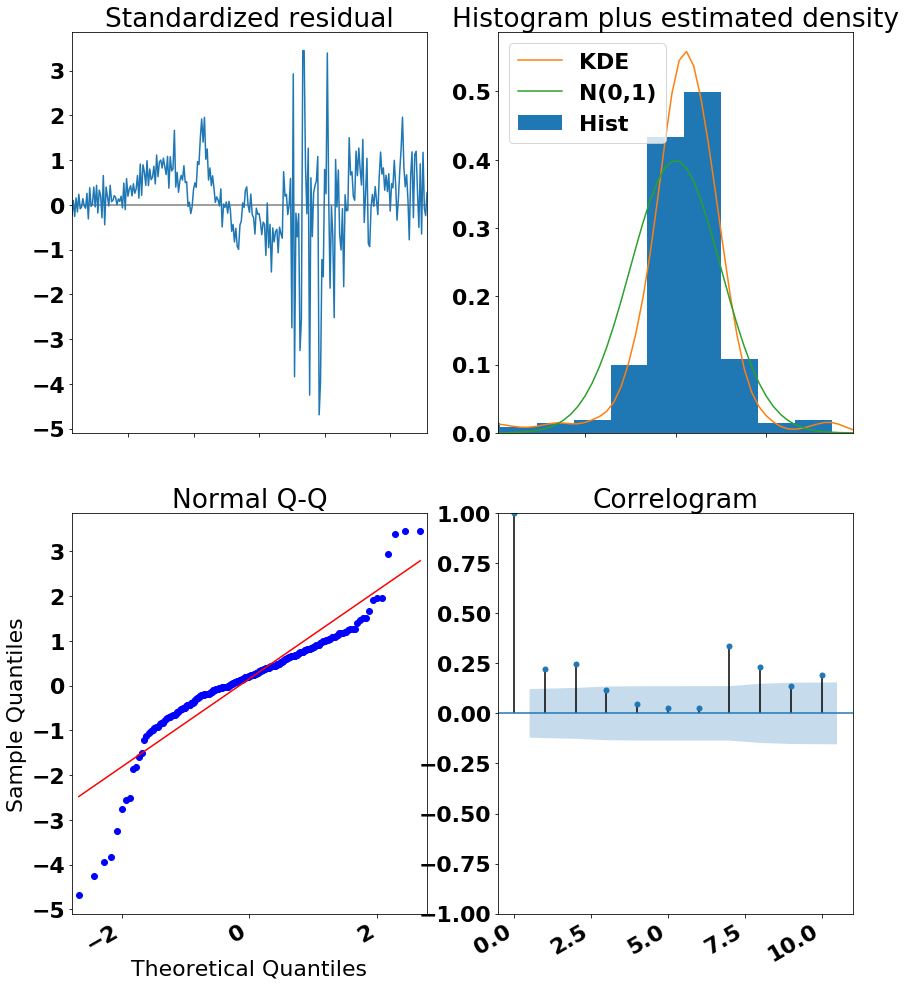

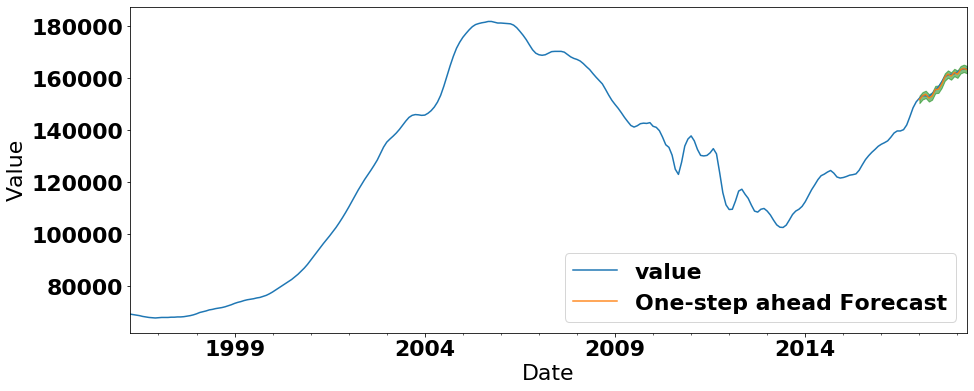

The Mean Squared Error of our forecasts is 295427.41


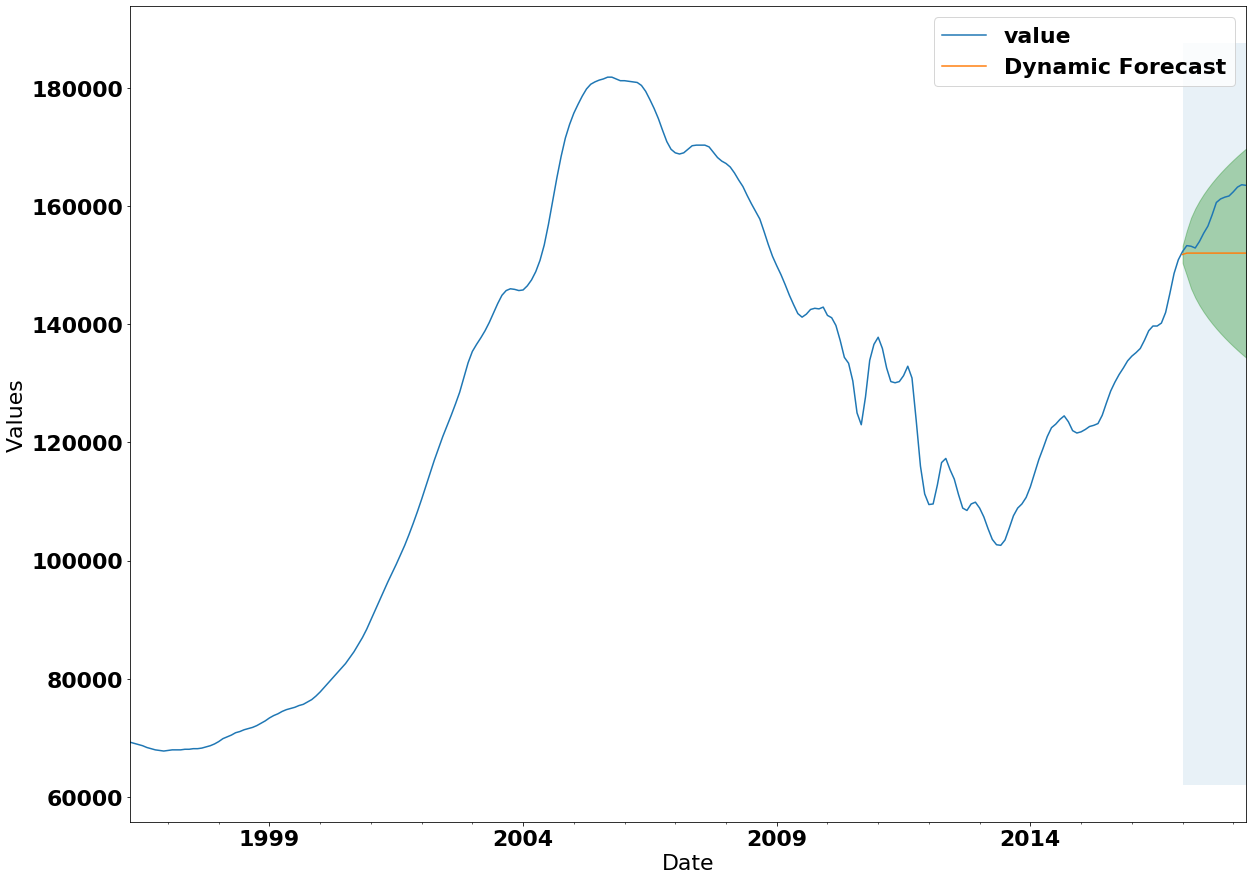

The Mean Squared Error of our forecasts is 57448183.69


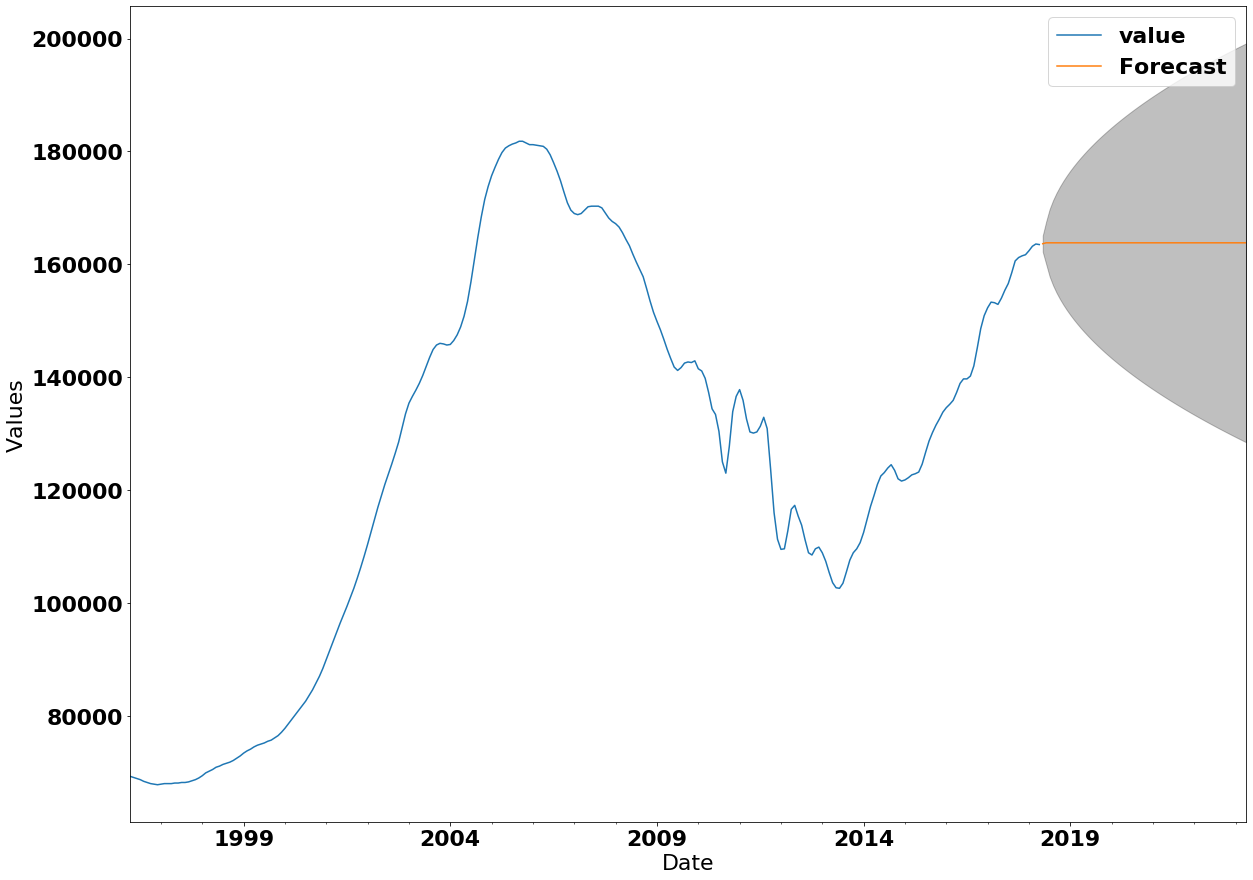

In [38]:
arima_test(boston_model_ts, best_boston_model_cfg)

## Observations for Boston 03868
1. All p-values are below 0.05
2. Looking at the diagnostic plots, these are the worst of the group and you can tell the model will not be very good.  
3. Looking at the first prediction plot. The model seems to be doing very well.
4. The dynamic forecast seems to be pretty off and shows no increase or decrease. This is probably because there is much more fluctuation between 2011 and 2018 and a large dip around 2013.  
5. Forecasting for the next 5 years shows no growth and the cone of uncertainty is rather large and unstable. 

# Step 6: Conclusions

If no outside circumstances are considered and based only off the data given. All zipcodes will likely to provide you a positive investment. If you have the large entry fee of buying in San Francisco, this will provide the highest ROI in the shortest amount of time, but all zipcodes should provide positive outcomes. According to the models though San Francisco and Austin are forecasted to be guaranteed profits. Boston comes out as the worst forecast and investing would truly be a gamble. 

# Step 7: Further Work

No model is ever truly done and further factors and ideas could be added.  None of these models account for inflation. That would be a good starting place to really see what the true ROI is. Further research into each zipcode should be implemented as well to see if perhaps there are any big developments or large companies opening HQs etc to boost housing prices. I would also like to do more with the forward step validation. Having a plot that plots one point at a time and shows the model doing better and better. And then having the actual values on the plot as well. 